# Whole-brain classification of movie time points
In this analysis, we classify which time point (TR) of the movie the participant was viewing by comparing the measured response patterns of the participant with the predicted patterns.
The predicted pattern is the average pattern across all other participants (i.e., leave-one-out).

We repeat the analysis with two different datasets (_Raiders_ and _Budapest_) and three alignment methods (surface alignment, Procrustes hyperalignment, warp hyperalignment), and we find consistent results across six repetitions.
The classification accuracy based on the `onavg` template is higher than based on other templates for all six repetitions.

## Preparations

### Import Python packages

In [1]:
import os
import numpy as np
import neuroboros as nb
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.interpolate import splrep, splev
from scipy.stats import ttest_rel

### Other settings

In [2]:
dsets = ['raiders', 'budapest']
colors = np.array(sns.color_palette('tab10'))
seeds = np.arange(100)
align_radius = 20
train_dur, test_dur = '1st-half', '2nd-half'
ico = 32
spaces = [f'fsavg-ico{ico}', f'fslr-ico{ico}', f'onavg-ico{ico}']
np.set_printoptions(4, linewidth=200)
if os.path.exists('Arial.ttf'):
    from matplotlib import font_manager
    font_manager.fontManager.addfont('Arial.ttf')
mpl.rcParams['font.family'] = 'Arial'

### Load results
- For simplicity, we use the optimal # of PCs based on the _Forrest_ dataset
- The results are very robust against the # of PCs (try changing `idx` in cell #4).

In [3]:
npc_indices = {
    ('surf', 'onavg-ico64'): 21,
    ('surf', 'fsavg-ico64'): 18,
    ('surf', 'fslr-ico64'): 17,
    ('surf', 'onavg-ico32'): 17,
    ('surf', 'fsavg-ico32'): 16,
    ('surf', 'fslr-ico32'): 15,
    ('procr', 'onavg-ico64'): 39,
    ('procr', 'fsavg-ico64'): 41,
    ('procr', 'fslr-ico64'): 41,
    ('procr', 'onavg-ico32'): 33,
    ('procr', 'fsavg-ico32'): 29,
    ('procr', 'fslr-ico32'): 31,
    ('ridge', 'onavg-ico64'): 25,
    ('ridge', 'fsavg-ico64'): 22,
    ('ridge', 'fslr-ico64'): 27,
    ('ridge', 'onavg-ico32'): 12,
    ('ridge', 'fsavg-ico32'): 14,
    ('ridge', 'fslr-ico32'): 12,
}

In [4]:
# cache file to avoid excessive I/O
summary_fn = f'wholebrain_clf/summary_ico{ico}.pkl'
if not os.path.exists(summary_fn):
    results = {}
    for dset_name in dsets:
        sids = nb.dataset(dset_name).subjects
        for align in ['surf', 'procr', 'ridge']:
            for space in spaces:
                idx = npc_indices[align, space]
                aa = []
                for sid in sids:
                    a = [np.load(f'wholebrain_clf/{dset_name}/{space}_{align}_'
                                 f'{align_radius}mm_{train_dur}_{test_dur}_'
                                 f'seed{seed:04d}/{sid}.npy')
                         for seed in seeds]
                    aa.append(np.mean(a, axis=0)[..., idx])
                aa = np.array(aa)
                results[dset_name, space, align] = aa
                print(dset_name, align, space, aa.shape)
    nb.save(summary_fn, results)
results = nb.load(summary_fn)

In [5]:
for key, val in results.items():
    print(key, val.shape) # (participants, number of training participants)
    break

('raiders', 'fsavg-ico32', 'surf') (23, 22)


## Accuracy of movie time point classification
- Two datasets (top: _Raiders_, bottom: _Budapest_)
- Three alignment methods (surface alignment, Procrustes hyperalignment, warp hyperalignment)
- Bars denote average accuracy across participants
- Grey lines denote individual participants

0.8612836438923394 0.9233954451345756 0.0016464590618267658


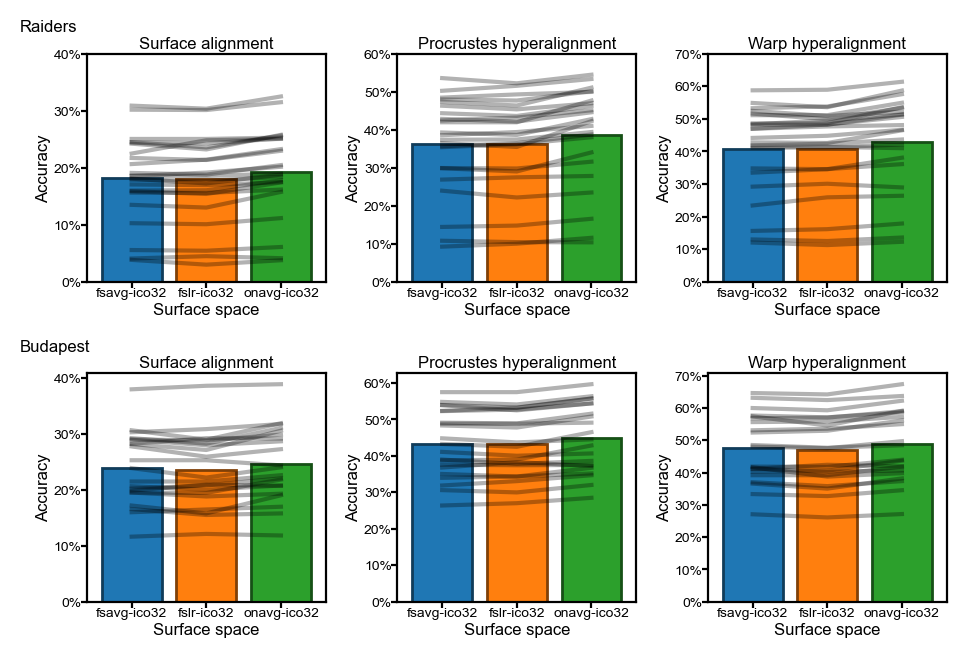

In [6]:
fig, axs = plt.subplots(2, 3, figsize=[_/2.54 for _ in (12, 8)], dpi=200)
pct1, pct2, pp = [], [], []
for ii, dset_name in enumerate(dsets):
    for jj, align in enumerate(['surf', 'procr', 'ridge']):
        ax = axs[ii, jj]
        ys = []
        for i, space in enumerate(spaces):
            a = results[dset_name, space, align][:, -1]
            m = a.mean(axis=0)
            c = colors[i]
            ax.bar(i, m, facecolor=c, edgecolor=c*0.5, ecolor=c*0.5)
            ys.append(a)
        ax.set_xticks(np.arange(3), labels=spaces)

        ys = np.array(ys)
        for y in ys.T:
            ax.plot(np.arange(3), y, 'k-', alpha=0.3, markersize=1)
        t, p = ttest_rel(ys[2], ys[0])
        pp.append(p)
        assert p < 0.005
        t, p = ttest_rel(ys[2], ys[1])
        pp.append(p)
        assert p < 0.005
        pct1.append(np.mean(ys[0] < ys[2]))
        pct2.append(np.mean(ys[1] < ys[2]))

        max_ = int(np.ceil(ys.max() * 10))
        yy = np.arange(max_ + 1) * 0.1
        ax.set_yticks(yy, labels=[f'{_*100:.0f}%' for _ in yy])
        ax.set_xlim([-0.6, 2.6])
        ax.tick_params(axis='both', pad=0, length=2, labelsize=5)
        ax.set_ylabel('Accuracy', size=6, labelpad=1)
        ax.set_xlabel('Surface space', size=6, labelpad=1)
        title = {'procr': 'Procrustes hyperalignment',
                 'ridge': 'Warp hyperalignment',
                 'surf': 'Surface alignment'}[align]
        ax.set_title(f'{title}', size=6, pad=2)
    axs[ii, 0].annotate(
        dset_name.capitalize(), (-0.28, 1.15),
        xycoords='axes fraction', size=6, va='top', ha='left')
print(np.mean(pct1), np.mean(pct2), np.max(pp))
fig.subplots_adjust(left=0.08, right=0.99, top=0.93, bottom=0.06,
                    wspace=0.3, hspace=0.4)
plt.savefig('wholebrain_bar.png', dpi=300, transparent=True)
plt.show()

## Difference of classification accuracy between template spaces
- The difference accuracy between `onavg` and fsavg (blue bars), and between `onavg` and fslr (orange bars)
- The differences are statistically significant (_p_ < 0.01) across different datasets and alignment methods

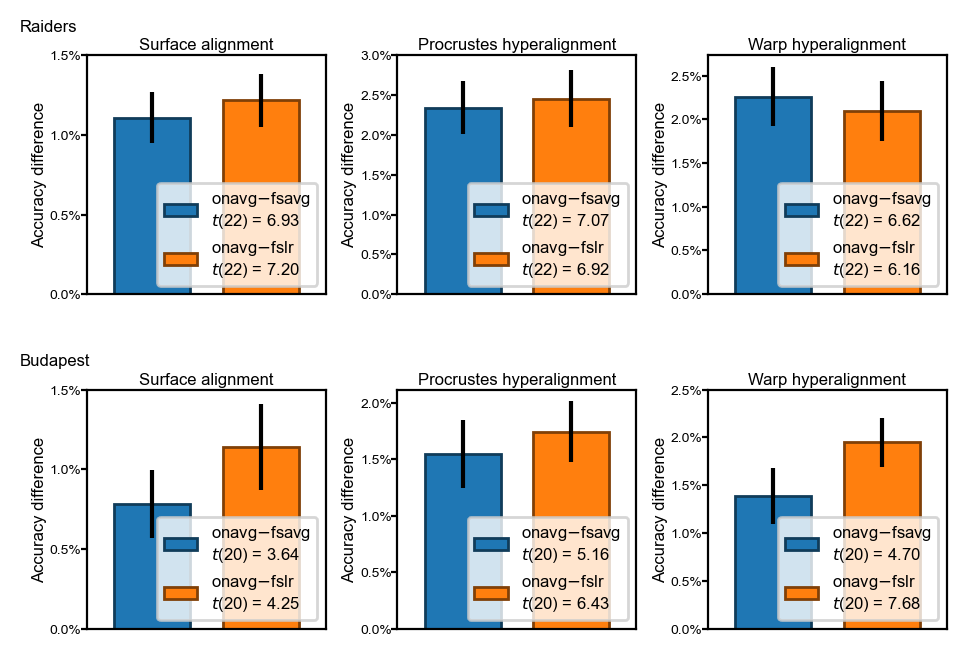

In [7]:
fig, axs = plt.subplots(
    2, 3, figsize=[_/2.54 for _ in [12, 8]], dpi=200)
pct1, pct2, pp = [], [], []
for ii, dset_name in enumerate(dsets):
    for jj, align in enumerate(['surf', 'procr', 'ridge']):
        ax = axs[ii, jj]

        max_ = []
        onavg = results[dset_name, spaces[-1], align][:, -1]
        for kk, space in enumerate(spaces[:2]):
            y = onavg - results[dset_name, space, align][:, -1]
            m = y.mean(axis=0)
            se = y.std(axis=0, ddof=1) / np.sqrt(y.shape[0])
            c = colors[kk]
            t, p = ttest_rel(onavg, results[dset_name, space, align][:, -1])
            dof = len(onavg) - 1
            label = f'{spaces[-1].split("-")[0]}$ - ${spaces[kk].split("-")[0]}'\
                    f'\n$t$({dof}) = {t:.2f}'
            ax.bar(kk, m, yerr=se, color=c, ec=c*0.5, width=0.7, label=label)
            max_.append(m + se)
            assert p < 0.01
        max_ = int(np.ceil(np.max(max_) * 1.1 * 1000))

        ax.set_xticks([])
        ax.set_xlim(np.array([-0.6, 1.6]))
        yy = np.arange(0, max_ + 1, 5)
        ax.set_yticks(yy  * 0.001, labels=[f'{_*0.1:.1f}%' for _ in yy])
        ax.set_ylabel('Accuracy difference', size=6, labelpad=1)
        ax.tick_params(axis='both', pad=0, length=2, labelsize=5)

        title = {'procr': 'Procrustes hyperalignment',
                 'ridge': 'Warp hyperalignment',
                 'surf': 'Surface alignment',
                }[align]
        ax.set_title(f'{title}', size=6, pad=2)
        ax.legend(fontsize=6, fancybox=True, loc='lower right')
    axs[ii, 0].annotate(
        dset_name.capitalize(), (-0.28, 1.15),
        xycoords='axes fraction', size=6, va='top', ha='left')
fig.subplots_adjust(
    left=0.08, right=0.99, top=0.93, bottom=0.02, wspace=0.3, hspace=0.4)
plt.savefig('wholebrain_bar_diff.png', dpi=300, transparent=True)
plt.show()

## Classification accuracy with smaller numbers of participants
- Classification accuracy is lower with less training data (less training participants)
- With the same amount of data, accuracy based on the `onavg` template is higher than based on other templates
- The same classification accuracy can be achieved with less data when using `onavg` compared with other templates

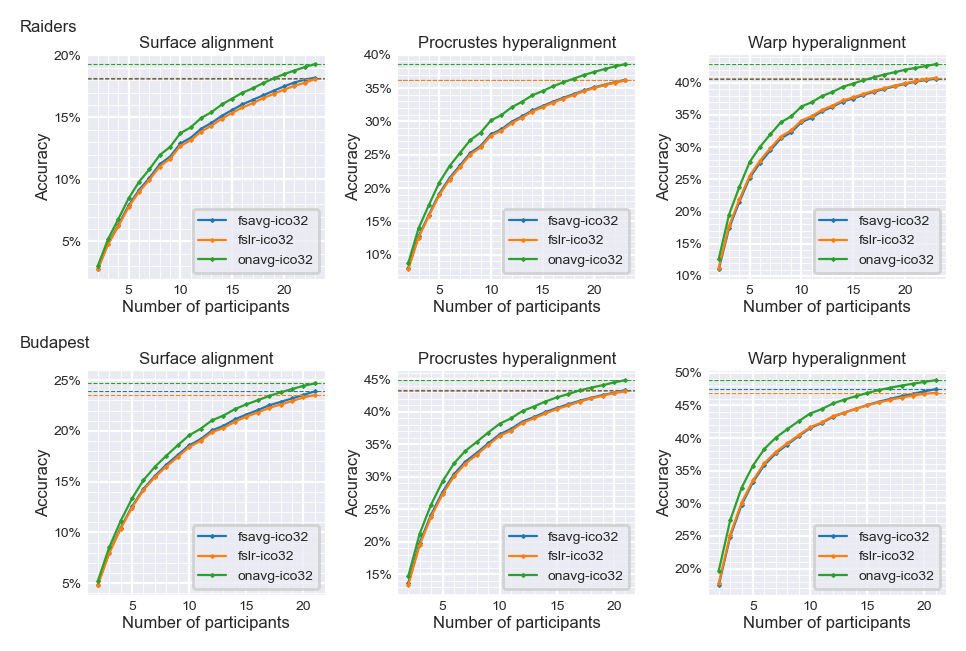

In [8]:
with sns.axes_style('darkgrid'):
    fig, axs = plt.subplots(2, 3, figsize=[_/2.54 for _ in (12, 8)], dpi=200)
    for ii, dset_name in enumerate(dsets):
        for jj, align in enumerate(['surf', 'procr', 'ridge']):
            ax = axs[ii, jj]
            ys = np.array([
                results[dset_name, space, align].mean(axis=0) for space in spaces])
            x = np.arange(len(ys[0])) + 2
            for i, (y, space) in enumerate(zip(ys, spaces)):
                ax.plot(x, y, 'x-', color=colors[i],
                        markersize=1, lw=0.8, label=space)
                ax.axhline(y[-1], color=colors[i], linestyle='--', lw=0.4, alpha=1)
            max_, min_ = ys.max(), ys.min()
            extra = (max_ - min_) * 0.02
            arng = np.arange(int(np.floor((min_ - extra) * 100)),
                             int(np.ceil((max_ + extra) * 100))+ 1)
            yy = [_*0.01 for _ in arng if _ % 5 == 0]
            ax.set_yticks(yy, labels=[f'{_*100:.0f}%' for _ in yy])
            ax.set_yticks(arng * 0.01, minor=True)
            ax.set_xticks(x, minor=True)
            ax.tick_params(axis='both', pad=0, length=2, labelsize=5)
            ax.grid(visible=True, which='minor', color='w', linewidth=0.3)
            title = {'procr': 'Procrustes hyperalignment',
                     'ridge': 'Warp hyperalignment',
                     'surf': 'Surface alignment'}[align]
            ax.set_title(f'{title}', size=6, pad=2)
            ax.set_ylabel('Accuracy', labelpad=1, size=6)
            ax.set_xlabel('Number of participants', size=6, labelpad=1)
            ax.legend(fontsize=5)
        axs[ii, 0].annotate(
            dset_name.capitalize(), (-0.28, 1.15),
            xycoords='axes fraction', size=6, va='top', ha='left')
    fig.subplots_adjust(
        left=0.08, right=0.99, top=0.93, bottom=0.07, wspace=0.3, hspace=0.4)
    plt.savefig(f'wholebrain_line.png', dpi=300, transparent=False)
    plt.show()

## Number of participants needed to achieve the same accuracy
- The same classification accuracy can be achieved with less data when using `onavg` compared with other templates

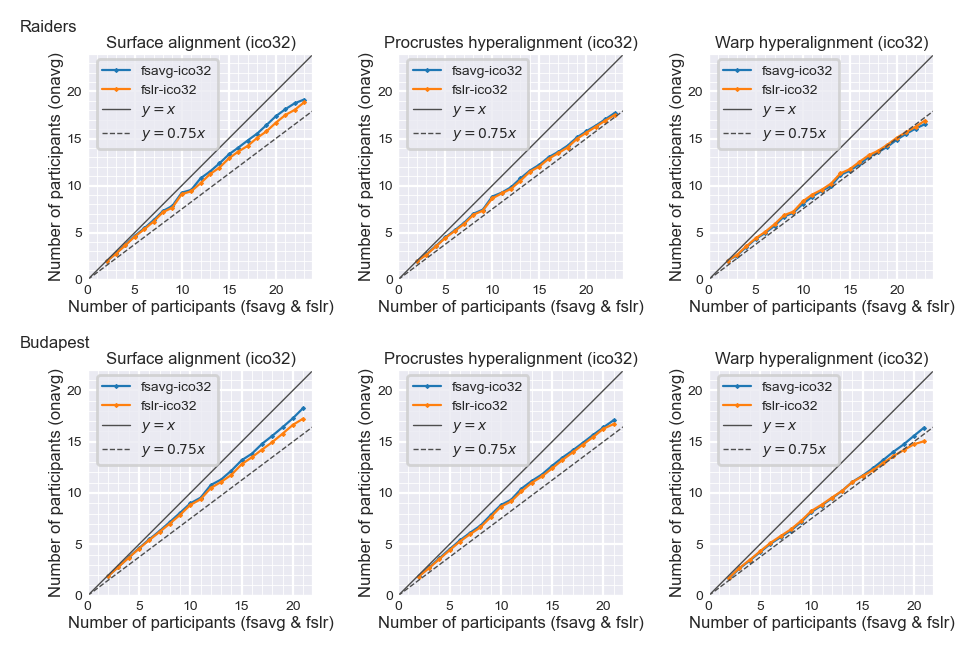

In [9]:
with sns.axes_style('darkgrid'):
    fig, axs = plt.subplots(2, 3, figsize=[_/2.54 for _ in (12, 8)], dpi=200)
    for ii, dset_name in enumerate(dsets):
        for jj, align in enumerate(['surf', 'procr', 'ridge']):
            ax = axs[ii, jj]
            ys = [results[dset_name, space, align].mean(axis=0) for space in spaces]
            x = np.arange(len(ys[0])) + 2
            reps = [splrep(x, y) for y in ys]
            reps2 = [splrep(y, x) for y in ys]
            for i, space in enumerate(spaces[:2]):
                z = splev(splev(x, reps[i]), reps2[-1])
                ax.plot(x, z, 'x-', color=colors[i],
                        markersize=1, lw=0.8, label=space)
            ax.tick_params(axis='both', pad=0, length=2, labelsize=5)
            yy = np.arange(5)+1
            title = {'procr': 'Procrustes hyperalignment',
                     'ridge': 'Warp hyperalignment',
                     'surf': 'Surface alignment'}[align]
            title += f' (ico{ico})'
            ax.set_title(title, size=6, pad=2)
            ax.set_ylabel('Number of participants (onavg)', size=6, labelpad=1)
            ax.set_xlabel('Number of participants (fsavg & fslr)', size=6,
                          labelpad=1)
            ns = x.max()
            lim = np.array([0, ns + 1])
            ax.plot(lim, lim, '-', lw=0.5, color=[0.3]*3, label='$y=x$')
            ax.plot(lim, lim*0.75, '--', lw=0.5, color=[0.3]*3, label='$y=0.75x$')
            ax.set_xlim(lim)
            ax.set_ylim(lim)
            ax.set_yticks(np.arange(0, ns + 1, 5))
            ax.set_xticks(np.arange(0, ns + 1, 5))
            ax.set_xticks(np.arange(ns + 1), minor=True)
            ax.set_yticks(np.arange(ns + 1), minor=True)
            ax.grid(visible=True, which='minor', color='w', linewidth=0.3)
            ax.set_aspect('equal')
            ax.legend(fontsize=5, loc=(0.04, 0.58))
        axs[ii, 0].annotate(
            dset_name.capitalize(), (-0.3, 1.15),
            xycoords='axes fraction', size=6, va='top', ha='left')
    fig.subplots_adjust(
        left=0.08, right=0.99, top=0.93, bottom=0.07, wspace=0.3, hspace=0.4)
    plt.savefig(f'wholebrain_sample_size.png', dpi=300)
    plt.show()